# Optimizing SR on Ideal Topography

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import params_ideal as params

from fun_ideal import calc_flood_height, generate_groups, calc_group_vol, calc_group_h, get_wall_heights
from ideal_damage import Damage
from topo_ideal import Topo

In [32]:
topo_file = "Input/ideal_topo_gp_points_1.csv"

storm_file = "../SurgeData/0-waterlevel_w.csv"
storm_file_c = "../SurgeData/0-waterlevel_c.csv"
div_data_file = "Input/ideal_div_data.csv"
time_file = "../SurgeData/0-time_w.csv"
time_file_c = "../SurgeData/0-time_c.csv"
damage_table_file = "Input/damage_table_combined.csv"

In [33]:
#surge = pd.read_csv(storm_file).to_numpy()
#surge_time = pd.read_csv(time_file).to_numpy()

surge = np.concatenate((pd.read_csv(storm_file).to_numpy(), pd.read_csv(storm_file_c).to_numpy()), axis=0)
surge_time = np.concatenate((pd.read_csv(time_file).to_numpy(), pd.read_csv(time_file_c).to_numpy()), axis=0)
damage_table = pd.read_csv(damage_table_file)


Topo = Topo(topo_file=topo_file)
Damage = Damage(damage_table_file)

In [34]:
# generate groups
#groups = generate_groups(Topo.div_data)

segment_l = 100
wall_height = np.zeros(Topo.shore_height.size)

# Infinite Water Travel
(Water level is assumed to reach equilibrium)

# Single Ensemble Uniform Allocation
Allocates same height across the topo (Note: might not make difference if on uniform topo)

In [12]:
params.travel_dist = 999

divs_allocate = list(range(18))
groups = generate_groups(Topo.div_data)

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 3
h_num = 100


wall_height[positions] = h_start

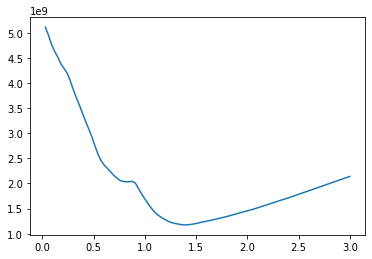

In [13]:
points = []
for h in np.linspace(h_start, h_end, num=h_num):
    wall_height[:] = 0
    wall_height[positions] = h

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    cost_dmg = np.sum(dmg)
    cost_wall = np.sum(49212 * wall_height * segment_l)
    cost_tot = cost_dmg + cost_wall
    
    if h != 0:
        points.append([h, cost_wall, cost_dmg, cost_tot, volume_div[0,0], volume_div[4,0], volume_div[0, 10], volume_div[4,10], volume_grouped[0,0], volume_grouped[4,0]])
    
df = pd.DataFrame(points)
#df.to_csv("Output/full_uniform_wall_opt.csv")
#print(df)
plt.figure()
plt.plot(df.iloc[:,0], df.iloc[:,3])

Plot minimum height of shore topography instead of wall height

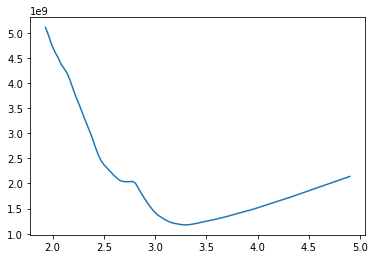

In [14]:
min_height = np.min(Topo.shore_height)
plt.figure()
plt.plot(df.iloc[:,0] + min_height, df.iloc[:,3])

# Single Ensemble Even Allocation
Allocates to even out topo

In [39]:
params.travel_dist = 999


groups = generate_groups(Topo.div_data)
        
h_max = 5
dh = 0.05


min_height = np.min(Topo.shore_height)
N = int(np.max(np.ceil((h_max - min_height)/dh), 0))

In [45]:
points = []
for n in range(N):
    height = min_height + n*dh

    pos, wall_heights = get_wall_heights(Topo, height) 

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_heights, pos)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)
    print(height_grouped[:,0])

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    dmg_per_storm = np.sum(dmg, axis=1)
    dmg_per_div = np.sum(dmg, axis=0)
    dmg_tot = np.sum(dmg_per_div)
    cost_wall = np.sum(49212 * wall_heights * segment_l)
    cost_tot = dmg_tot + cost_wall
    
    if n != 0: 
        points.append([height, cost_wall, dmg_tot, cost_tot, *dmg_per_storm])
    
df = pd.DataFrame(points)
#df.to_csv("Output/full_even_wall_opt_2.csv")
#print(df)

[0.35251399 0.56917729 1.01113218 0.12342188 2.82823782 3.06617142
 3.40721452 0.8418549  1.32917119 2.15010895 1.78263846 2.63568072
 1.80813769 0.39691236 0.77478919 0.38350091 0.3005081  1.06436187
 0.56497079 1.96820907 1.04894341 1.28407107 0.768156   1.72654445
 0.23054347 0.67464762 0.69770822 0.58775414 1.03041643 0.1010887
 0.63133016 1.03362807 1.49232411 0.87262343 1.85199826 0.53536789
 0.8382371  1.33116502 0.55655783 0.22547926 0.79554827 0.21310697
 1.49275262 0.62712288 0.57322567 1.17354684 0.50714389 0.4945713
 0.23649487 0.72406476 0.87303285 0.57793933 0.6113778  1.2748692
 0.57344024 0.9281705  0.34117745 3.03695751 1.4525848  0.19740922
 1.21743869 0.59822409 1.49178664 0.4597132  0.28181432 1.02665824
 1.66760628 1.27884086 0.89104622 0.22585005 1.05614541 1.60513374]
[0.19943729 0.33041511 0.74695529 0.         2.43040957 3.06617142
 3.40721452 0.52169442 1.02822783 1.79649209 1.45419305 2.31458117
 1.43742326 0.1976907  0.52220701 0.14497116 0.09286194 0.781256

[0.         0.         0.         0.         0.70223662 1.95759921
 2.78011719 0.         0.         0.32839709 0.         0.36441529
 0.         0.         0.         0.         0.         0.
 0.         0.58000146 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.72808098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.         0.         0.         0.         0.58870271 1.74554102
 2.5913479  0.         0.         0.20437249 0.         0.1722599
 0.         0.         0.         0.         0.         0.
 0.         0.46597438 0.         0.         0.         0.
 0.         0.  

[0.         0.         0.         0.         0.         0.
 0.97586611 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.81333475 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Text(0, 0.5, 'Damage ($)')

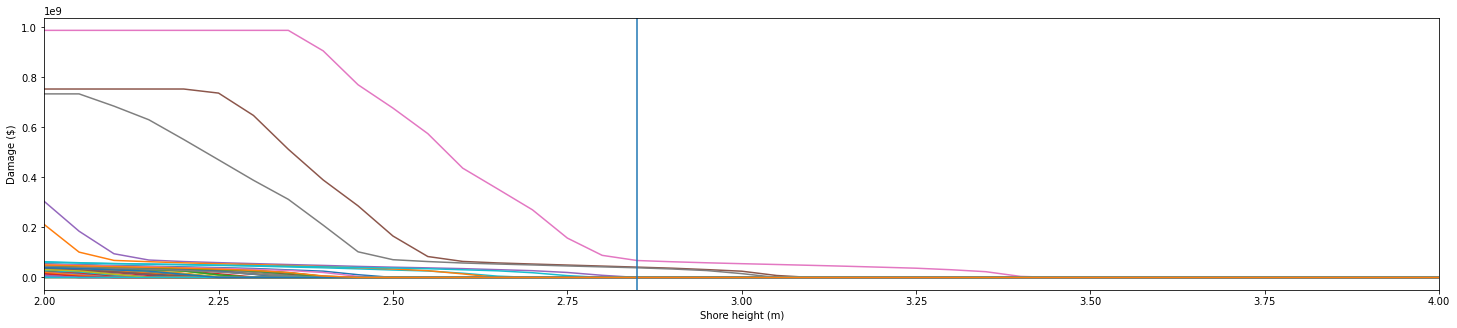

In [43]:
fig = plt.figure()
for d in range(dmg_per_storm.size):
    plt.plot(df.iloc[:,0], df.iloc[:,4+d])
fig.set_size_inches(25,5)
plt.xlim(2, 4)
# plt.ylim(0, 0.8*1e7)

opt_arg = np.argmin(df.iloc[:,3])
opt_cost_wall = df.iloc[:,1][opt_arg]
opt_height = df.iloc[:,0][opt_arg]
plt.axvline(x=opt_height)
plt.xlabel(r"Shore height (m)")
plt.ylabel(r"Damage ($)")

18
147681414.79479223


Text(0, 0.5, 'Damage cost ($)')

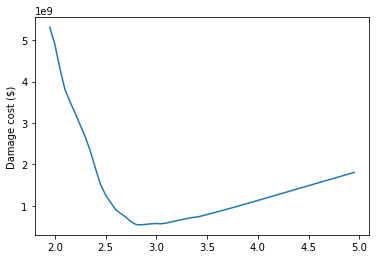

In [44]:
plt.figure()
plt.plot(df.iloc[:,0], df.iloc[:,3])
print(opt_arg)
print(df.iloc[:,2][opt_arg])
plt.ylabel(r"Damage cost ($)")

# Single Ensemble Even Allocation w. Avg Fitted Volume Func
This is no longer very relevant. Should behave very similar to normal volume function which is fitted to use slope which fits full domain surface volume points best and uses real slopes (or avg of real slopes oer domain) for manning eq. This uses the a*root(v) + b*V surface volume func fitted to all surfaceV points.

In [20]:
def calc_group_h_fitted_avg(Topo, groups, volume_grouped, surge_peak):
    # HARDCODED, calculates volume in each division with volume function fitted to all divs, very rough 
    height_group = np.zeros(volume_grouped.shape)
    
    for div in range(height_group.shape[1]):
        vol = volume_grouped[:,div] / 18 # Ha
        height_group[:, div] = np.minimum(2.94116829e-03 * np.sqrt(vol) - 3.36575759e-07*vol, surge_peak)
    return height_group

params.travel_dist = 999


groups = generate_groups(Topo.div_data)
        
h_max = 5
dh = 0.01


min_height = np.min(Topo.shore_height)
N = int(np.max(np.ceil((h_max - min_height)/dh), 0))

In [21]:
points = []
for n in range(N):
    height = min_height + n*dh

    pos, wall_heights = get_wall_heights(Topo, height) 

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_heights, pos)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h_fitted_avg(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    dmg_all_divs = np.sum(dmg, axis=1)
    cost_dmg = np.sum(dmg)
    cost_wall = np.sum(49212 * wall_heights * segment_l)
    cost_tot = cost_dmg + cost_wall

    if n != 0:
        points.append([height, cost_wall, cost_dmg, cost_tot, height_grouped[4,1], *dmg_all_divs])
    
df = pd.DataFrame(points)
#%matplotlib notebook
# for d in range(dmg_all_divs.size):
#     plt.plot(df.iloc[:,1], df.iloc[:,4+d])

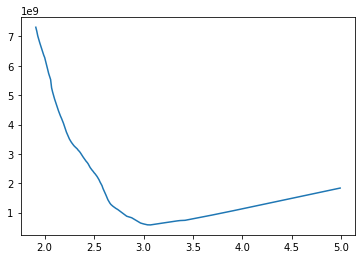

In [22]:
plt.plot(df.iloc[:,0], df.iloc[:,3])